# Homework 2: Credit Card Default Prediction
## Eliya Allam [870871]
**Course:** Data Science in Action  
**Objective:** To build a robust machine learning pipeline that predicts whether a credit card client will default on their payment next month.

## 1. Introduction and Project Setup
The goal of this analysis is to simulate a real-world data science project involving credit risk assessment. We are working with the "Default of Credit Card Clients" dataset, which contains demographic information, payment history, and billing data for 30,000 clients in Taiwan.

**Our Analysis Strategy:**
1.  **Data Exploration & Cleaning:** We will inspect the data for inconsistencies, handle missing values, and analyze distributions.
2.  **Feature Engineering:** We will augment the dataset with new features (e.g., Credit Utilization Ratios) to capture behavioral risk patterns.
3.  **Model Development:** We will establish a naive baseline and then train three sophisticated classifiers: Logistic Regression, Random Forest, and Gradient Boosting.
4.  **Optimization:** We will fine-tune our best model using hyperparameter search strategies and experiment with dimensionality reduction (PCA).

### Libraries Used
We utilize the standard Python Data Science stack:
* **Pandas & NumPy:** For efficient data manipulation, aggregation, and mathematical operations.
* **Matplotlib & Seaborn:** For visualizing distributions, correlations, and results.
* **Scikit-Learn (sklearn):** The core machine learning library used for:
    * **Preprocessing:** `StandardScaler`, `OneHotEncoder`.
    * **Model Selection:** `train_test_split`, `GridSearchCV`, `RandomizedSearchCV`.
    * **Models:** `LogisticRegression`, `RandomForestClassifier`, `GradientBoostingClassifier`, `DummyClassifier`.
    * **Metrics:** `accuracy_score`, `recall_score`, `f1_score`, `roc_auc_score`.
    * **Decomposition:** `PCA` for dimensionality reduction.

## 1.1 Data Loading and Initial Exploration
In this step, we load the raw dataset and perform a preliminary inspection.
* **`df.head()`:** Allows us to verify that the CSV loaded correctly and understand the column structure (e.g., `PAY_0` to `PAY_6` representing monthly repayment status).
* **`df.info()`:** Critical for identifying data types (integers vs. floats vs. strings) and spotting missing values (null counts).

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#set aesthetic parameters for plots
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

#load the dataset
#we reload from the CSV to ensure a completely fresh start
df = pd.read_csv('UCI_Credit_Card_final.csv')

#display the first 5 rows to verify headers and data format
print("First 5 rows of the dataset:")
display(df.head())

#display basic information about data types and non-null counts
print("\nDataset Info:")
df.info()

First 5 rows of the dataset:


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,female,university,married,24,2,2,0,0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1.0
1,2,120000.0,female,university,single,26,0,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1.0
2,3,90000.0,female,university,single,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0.0
3,4,50000.0,female,university,married,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0.0
4,5,50000.0,male,university,married,57,0,0,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0.0



Dataset Info:
<class 'pandas.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  str    
 3   EDUCATION                   29986 non-null  str    
 4   MARRIAGE                    29946 non-null  str    
 5   AGE                         30000 non-null  int64  
 6   PAY_1                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   29850 non-null  float64
 13  BILL_AMT2                  

### Summary Statistics and Missing Value Analysis
Here we compute descriptive statistics to understand the central tendency and spread of our data.
**Key Observations:**
1.  **Missing Values:** The output reveals that `EDUCATION`, `MARRIAGE`, and the `BILL_AMT` columns contain missing data. Crucially, the target variable `default.payment.next.month` also has missing rows, which must be addressed.
2.  **Scale Differences:** We observe massive differences in scale. `LIMIT_BAL` ranges up to 1,000,000, while `PAY_1` is a small integer (-2 to 8). This confirms the need for **Feature Scaling** later.
3.  **Class Imbalance:** The target distribution shows that approx. **78%** of clients did not default, while **22%** did. This imbalance means "Accuracy" will be a misleading metric, and we should focus on **Recall** (sensitivity to defaulters).

In [9]:
#display summary statistics for numerical features (transposed for easier reading)
print("\nSummary Statistics:")
display(df.describe().T)

#check for specific missing value counts
print("\nMissing Values Count:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

#check the distribution of the target variable to see if classes are balanced
print("\nTarget Variable Distribution:")
print(df['default.payment.next.month'].value_counts(normalize=True))


Summary Statistics:


,count,mean,std,min,25%,50%,75%,max
ID,30000.0,1.500050e+04,8.660398e+03,1.0,7500.75,15000.5,22500.25,3.000000e+04
LIMIT_BAL,30000.0,1.674843e+05,1.297477e+05,10000.0,50000.00,140000.0,240000.00,1.000000e+06
AGE,30000.0,3.548550e+01,9.217904e+00,21.0,28.00,34.0,41.00,7.900000e+01
PAY_1,30000.0,3.567667e-01,7.605942e-01,0.0,0.00,0.0,0.00,8.000000e+00
PAY_2,30000.0,3.200333e-01,8.017274e-01,0.0,0.00,0.0,0.00,8.000000e+00
PAY_3,30000.0,3.040667e-01,7.905890e-01,0.0,0.00,0.0,0.00,8.000000e+00
PAY_4,30000.0,2.587667e-01,7.611126e-01,0.0,0.00,0.0,0.00,8.000000e+00
PAY_5,30000.0,2.215000e-01,7.177197e-01,0.0,0.00,0.0,0.00,8.000000e+00
PAY_6,30000.0,2.265667e-01,7.154378e-01,0.0,0.00,0.0,0.00,8.000000e+00
BILL_AMT1,29850.0,5.124887e+04,7.365806e+04,-165580.0,3570.25,22414.0,67190.00,9.645110e+05



Missing Values Count:
EDUCATION                      14
MARRIAGE                       54
BILL_AMT1                     150
BILL_AMT2                     150
BILL_AMT3                     150
BILL_AMT4                     150
BILL_AMT5                     150
BILL_AMT6                     150
default.payment.next.month     20
dtype: int64

Target Variable Distribution:
default.payment.next.month
0.0    0.778719
1.0    0.221281
Name: proportion, dtype: float64


### Exploratory Data Visualization
Visualizing the raw data helps confirm our statistical findings:
* **Target Distribution (Countplot):** Visually confirms the class imbalance (0 vs 1).
* **Limit Balance (Histogram):** Shows a right-skewed distribution; most people have lower credit limits, with a long tail of wealthy clients.
* **Age Distribution:** Indicates the dataset is centered around younger adults (20s and 30s), which may influence default rates.

C:\Users\allam\AppData\Local\Temp\ipykernel_17156\2076886055.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='default.payment.next.month', data=df, palette='viridis')


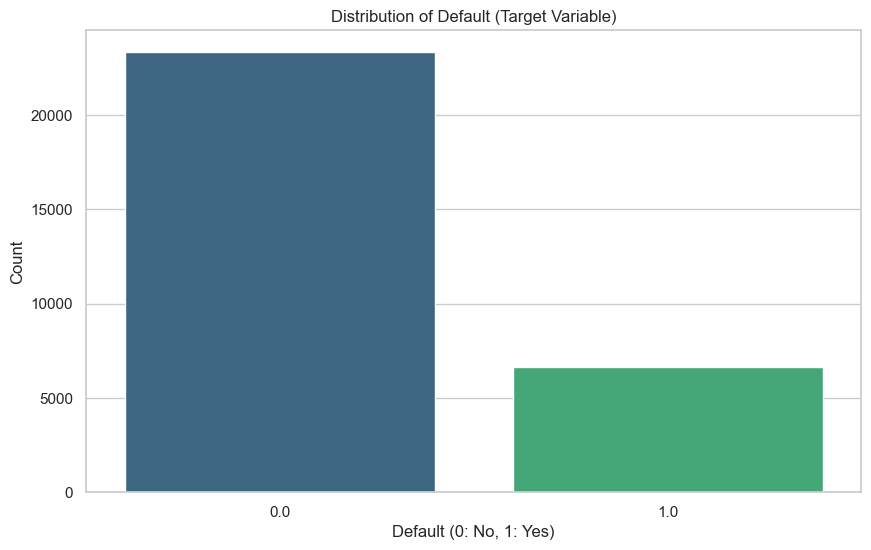

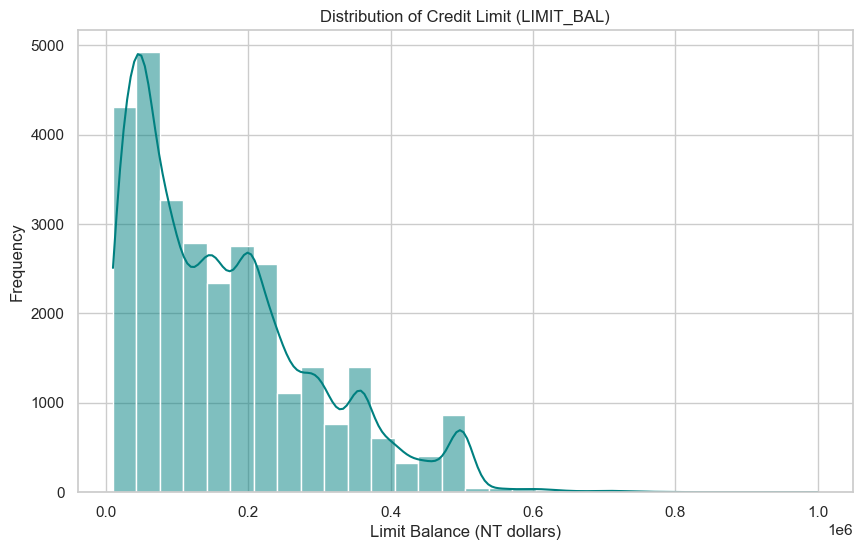

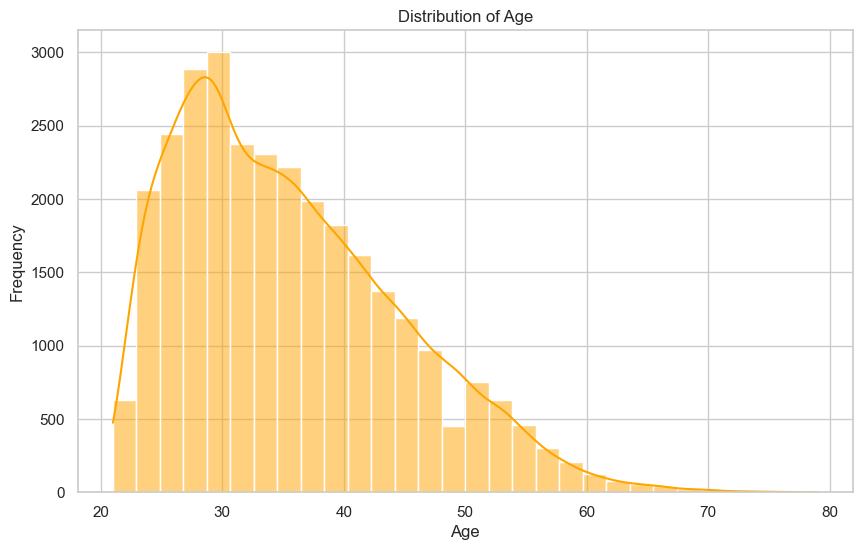

In [10]:
#1. visualize the target variable balance
plt.figure()
sns.countplot(x='default.payment.next.month', data=df, palette='viridis')
plt.title('Distribution of Default (Target Variable)')
plt.xlabel('Default (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

#2. visualize the distribution of Credit Limit (LIMIT_BAL)
plt.figure()
sns.histplot(df['LIMIT_BAL'], bins=30, kde=True, color='teal')
plt.title('Distribution of Credit Limit (LIMIT_BAL)')
plt.xlabel('Limit Balance (NT dollars)')
plt.ylabel('Frequency')
plt.show()

#3. visualize Age distribution
plt.figure()
sns.histplot(df['AGE'], bins=30, kde=True, color='orange')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

## 1.2 Data Preprocessing and Cleaning
Before modeling, we must clean the data to ensure it is numerical and complete.
**Actions Taken:**
1.  **Missing Targets:** We drop rows where the target label is missing (`dropna`), as these cannot be used for supervised learning.
2.  **Imputation:**
    * **Numerical (`BILL_AMT`):** We fill missing bills with the **median**. We chose median over mean because financial data often contains outliers that skew the mean.
    * **Categorical (`EDUCATION`, `MARRIAGE`):** We fill missing values with the **mode** (most frequent category).
3.  **Encoding:**
    * **`SEX`:** Converted to binary (0/1).
    * **`EDUCATION` & `MARRIAGE`:** Applied **One-Hot Encoding**. This converts categorical strings into binary columns (e.g., `EDUCATION_university`). We use `drop_first=True` to avoid multicollinearity (the "dummy variable trap").
4.  **Cleanup:** We drop the `ID` column as it carries no predictive information.

In [15]:

#1. create a copy to avoid SettingWithCopyWarning
df_clean = df.copy()

#2. handle Missing Target Values
#we cannot use data without a label for training/testing, so we drop these rows
df_clean = df_clean.dropna(subset=['default.payment.next.month'])

#3. impute Missing Numerical Values
#'BILL_AMT1' through 'BILL_AMT6' have 150 missing values each.
#we fill these with the median to be robust against outliers seen in the statistics
bill_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
for col in bill_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

#4. impute Missing Categorical Values
#'EDUCATION' and 'MARRIAGE' have small amounts of missing data. We fill with the mode (most frequent value).
cols_to_fill_mode = ['EDUCATION', 'MARRIAGE']
for col in cols_to_fill_mode:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

#5. encode Categorical Variables
#binary Encoding for SEX
df_clean['SEX'] = df_clean['SEX'].map({'female': 0, 'male': 1})

#One-Hot Encoding for 'EDUCATION' and 'MARRIAGE'
#this converts categories into binary columns (e.g., EDUCATION_university: 0 or 1)
#drop_first=True is used to avoid multicollinearity (dummy variable trap)
#added dtype=int to ensure columns are created as integers (0/1) instead of booleans
df_clean = pd.get_dummies(df_clean, columns=['EDUCATION', 'MARRIAGE'], drop_first=True, dtype=int)

#6. Final Cleanup
#drop the 'ID' column as it is an identifier, not a feature
if 'ID' in df_clean.columns:
    df_clean = df_clean.drop('ID', axis=1)

#rename the target column to something shorter and clearer
df_clean.rename(columns={'default.payment.next.month': 'Default'}, inplace=True)

#ensure the target is an integer (it was float due to NaNs previously)
df_clean['Default'] = df_clean['Default'].astype(int)

#verify the cleaning
print("Cleaned Dataframe Shape:", df_clean.shape)
print("\nMissing Values after cleaning:")
print(df_clean.isnull().sum().sum())
print("\nFirst 5 rows of transformed data:")
display(df_clean.head())

Cleaned Dataframe Shape: (29980, 28)

Missing Values after cleaning:
0

First 5 rows of transformed data:


,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default,EDUCATION_high school,EDUCATION_others,EDUCATION_university,EDUCATION_unknown,MARRIAGE_other,MARRIAGE_single
0,20000.0,0,24,2,2,0,0,0,0,3913.0,...,0.0,0.0,0.0,1,0,0,1,0,0,0
1,120000.0,0,26,0,2,0,0,0,2,2682.0,...,1000.0,0.0,2000.0,1,0,0,1,0,0,1
2,90000.0,0,34,0,0,0,0,0,0,29239.0,...,1000.0,1000.0,5000.0,0,0,0,1,0,0,1
3,50000.0,0,37,0,0,0,0,0,0,46990.0,...,1100.0,1069.0,1000.0,0,0,0,1,0,0,0
4,50000.0,1,57,0,0,0,0,0,0,8617.0,...,9000.0,689.0,679.0,0,0,0,1,0,0,0


## 1.3 Feature Engineering (Augmentation)
Raw data is often insufficient. Here, we create new "derived features" based on domain knowledge to help the model detect risk.
**New Features:**
1.  **Credit Utilization (`Avg_Utilization`):** Calculated as `BILL_AMT / LIMIT_BAL`. Clients who max out their credit cards are statistically riskier.
2.  **Payment Ratio (`Avg_Pay_Ratio`):** Calculated as `PAY_AMT / BILL_AMT`. This measures repayment behavior. A ratio < 1.0 implies the client is carrying debt forward (revolving).
3.  **Age Groups:** We bin `AGE` into decades (20s, 30s, etc.) and One-Hot Encode them. This allows the model to capture non-linear relationships (e.g., risk might be high for very young *and* very old clients, but low for middle-aged).

In [ ]:
#Step 1.3: Feature Engineering / Augmentation

#we create a fresh copy of df_clean to avoid modifying the original Step 1.2 output
df_aug = df_clean.copy()

#remove any potential duplicate columns from previous runs to prevent stacking
cols_to_reset = [col for col in df_aug.columns if 'Utilization' in col or 'Pay_Ratio' in col or 'Age_Group' in col or 'Avg_' in col]
if cols_to_reset:
    df_aug = df_aug.drop(columns=cols_to_reset)
    print(f"Safety Reset: Dropped {len(cols_to_reset)} pre-existing augmented columns to prevent duplicates.")

#2. Credit Utilization Ratio (BILL_AMT / LIMIT_BAL)
#we calculate this for each of the 6 months.
for i in range(1, 7):
    #add epsilon (1e-5) to LIMIT_BAL to safely handle rare cases of 0 limit, though unlikely
    df_aug[f'Utilization_{i}'] = df_aug[f'BILL_AMT{i}'] / (df_aug['LIMIT_BAL'] + 1e-5)

#create 'Avg_Utilization': A stable measure of how much credit the user typically uses
df_aug['Avg_Utilization'] = df_aug[[f'Utilization_{i}' for i in range(1, 7)]].mean(axis=1)


#3. Payment-to-Bill Ratio (PAY_AMT / BILL_AMT)
#we calculate what percentage of the bill was paid.
for i in range(1, 7):
    #logic: If Bill > 0, Ratio = Pay/Bill.
    #if Bill <= 0 (refund/no spend), Ratio = 1 (considered "paid up" or good standing).
    df_aug[f'Pay_Ratio_{i}'] = np.where(
        df_aug[f'BILL_AMT{i}'] > 0,
        df_aug[f'PAY_AMT{i}'] / df_aug[f'BILL_AMT{i}'],
        1
    )

#create 'Avg_Pay_Ratio': A stable measure of repayment behavior
df_aug['Avg_Pay_Ratio'] = df_aug[[f'Pay_Ratio_{i}' for i in range(1, 7)]].mean(axis=1)


#4. Age Binning (Non-linear patterns)
#we group AGE into decades: 20s, 30s, 40s, 50s, 60+
bins = [0, 30, 40, 50, 60, 100]
labels = ['20s', '30s', '40s', '50s', '60+']
df_aug['Age_Group_Bin'] = pd.cut(df_aug['AGE'], bins=bins, labels=labels)

#One-Hot Encode the Age Groups
#drop_first=True prevents multicollinearity (if all are 0, it implies the reference category)
#dtype=int ensures we get 0/1 instead of True/False
df_aug = pd.get_dummies(df_aug, columns=['Age_Group_Bin'], prefix='Age_Group', drop_first=True, dtype=int)


#5. Final Output Verification
print("Augmented Dataframe Shape:", df_aug.shape)

#Check specifically for duplicates in column names
if len(df_aug.columns) == len(set(df_aug.columns)):
    print("Duplicate Check: PASSED (All column names are unique)")
else:
    print("Duplicate Check: FAILED (Duplicates found)")

print("\nNew Features Added:")
#we verify we only see one set of age groups
print([col for col in df_aug.columns if 'Age_Group' in col])

display(df_aug.head())

Safety Reset: Dropped 10 pre-existing augmented columns to prevent duplicates.
Augmented Dataframe Shape: (29980, 46)
Duplicate Check: PASSED (All column names are unique)

New Features Added:
['Age_Group_30s', 'Age_Group_40s', 'Age_Group_50s', 'Age_Group_60+']


,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,Pay_Ratio_2,Pay_Ratio_3,Pay_Ratio_4,Pay_Ratio_5,Pay_Ratio_6,Avg_Pay_Ratio,Age_Group_30s,Age_Group_40s,Age_Group_50s,Age_Group_60+
0,20000.0,0,24,2,2,0,0,0,0,3913.0,...,0.222115,0.000000,1.000000,1.000000,1.000000,0.537019,0,0,0,0
1,120000.0,0,26,0,2,0,0,0,2,2682.0,...,0.579710,0.372856,0.305623,0.000000,0.613309,0.311916,0,0,0,0
2,90000.0,0,34,0,0,0,0,0,0,29239.0,...,0.106937,0.073752,0.069779,0.066899,0.321564,0.115141,1,0,0,0
3,50000.0,0,37,0,0,0,0,0,0,46990.0,...,0.041859,0.024345,0.038850,0.036914,0.033844,0.036396,1,0,0,0
4,50000.0,1,57,0,0,0,0,0,0,8617.0,...,6.469312,0.279057,0.429799,0.035987,0.035492,1.246958,0,0,1,0


## 2. Exploratory Data Analysis (EDA) on Augmented Data
Now that we have new features, we analyze their relationship with the target `Default`.
**Correlation Analysis (Heatmap):**
* **Findings:** The heatmap reveals that our new feature `Avg_Utilization` has a positive correlation with Default, validating our feature engineering.
* **Strongest Predictors:** The `PAY_X` variables (repayment status) remain the strongest predictors, followed by `Utilization`.
* **Demographics:** `SEX`, `MARRIAGE`, and `EDUCATION` show very weak correlations, suggesting that **financial behavior** is far more important than demographics for prediction.

**Boxplots:**
* **Utilization vs. Default:** clearly shows that defaulters (Class 1) tend to have higher credit utilization ratios than non-defaulters.

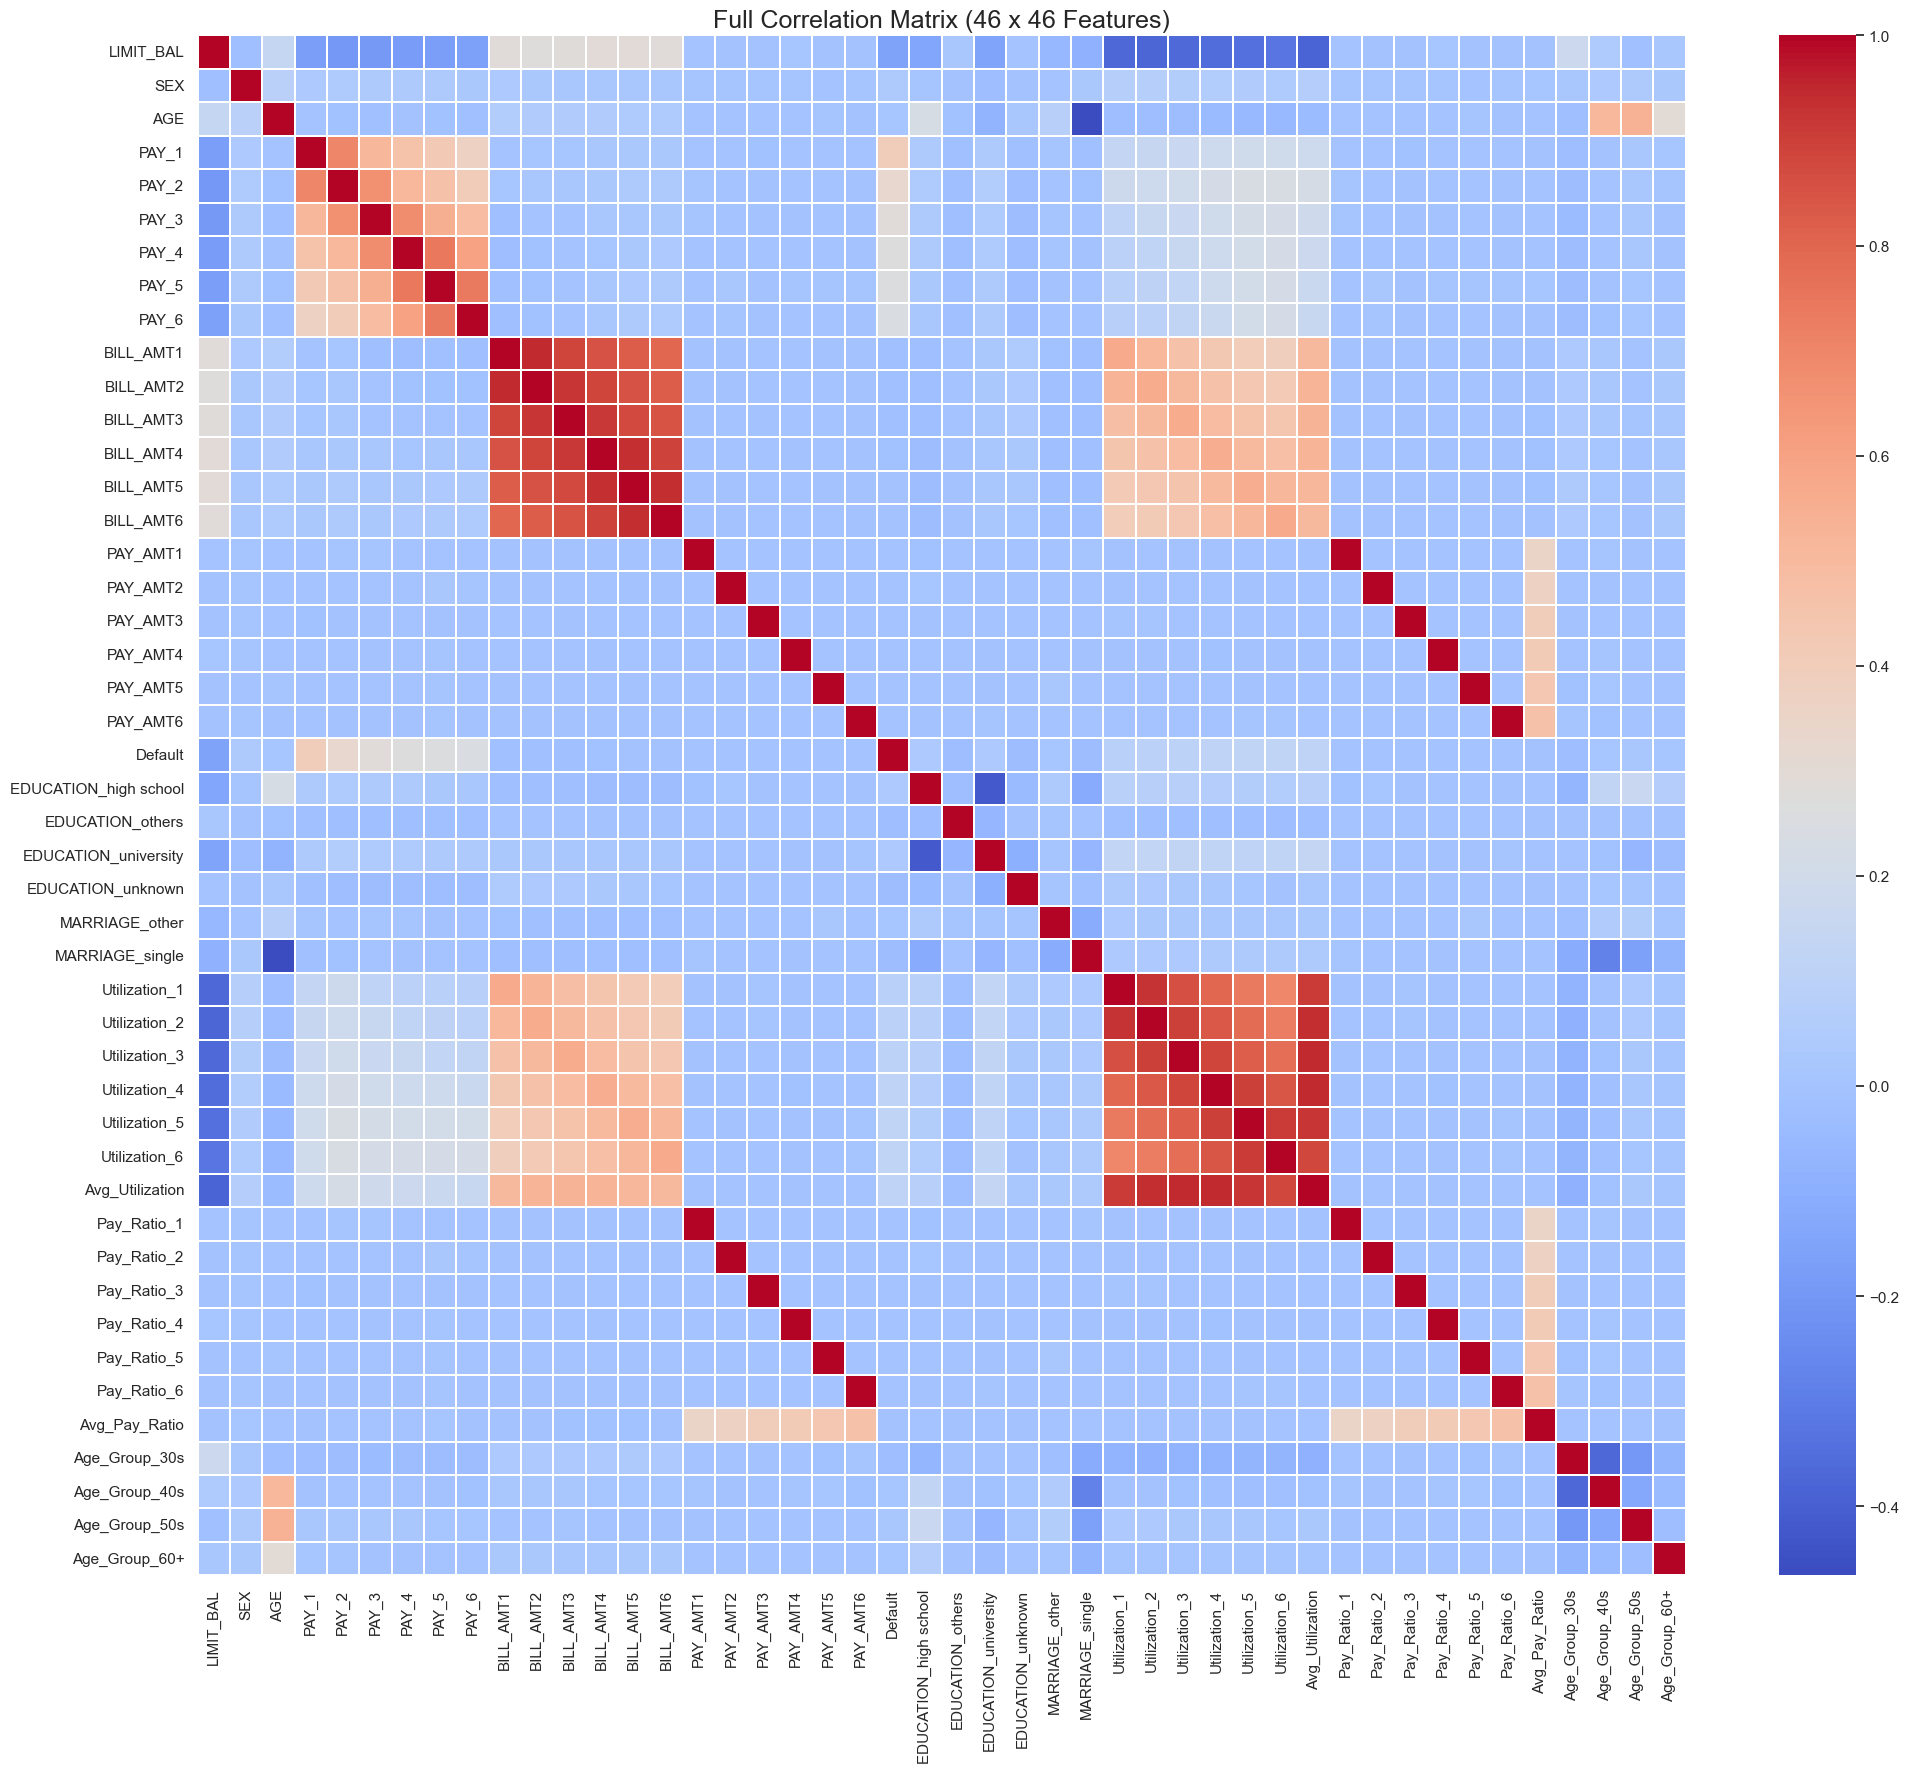

Top 10 Positive Correlations with Default:
Default          1.000000
PAY_1            0.396114
PAY_2            0.327166
PAY_3            0.287063
PAY_4            0.269124
PAY_5            0.260927
PAY_6            0.244508
Utilization_6    0.123711
Utilization_5    0.119950
Utilization_4    0.116797
Name: Default, dtype: float64

Top 10 Negative Correlations with Default:
LIMIT_BAL           -0.153566
EDUCATION_unknown   -0.036330
MARRIAGE_single     -0.031739
Age_Group_30s       -0.030141
EDUCATION_others    -0.025415
BILL_AMT1           -0.019095
BILL_AMT2           -0.014527
BILL_AMT3           -0.013541
BILL_AMT4           -0.009443
BILL_AMT5           -0.006219
Name: Default, dtype: float64


C:\Users\allam\AppData\Local\Temp\ipykernel_17156\2722366200.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Default', y='Avg_Utilization', data=df_aug, palette='viridis', ax=axes[0])
C:\Users\allam\AppData\Local\Temp\ipykernel_17156\2722366200.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Default', y='Avg_Pay_Ratio', data=df_aug, palette='coolwarm', ax=axes[1])


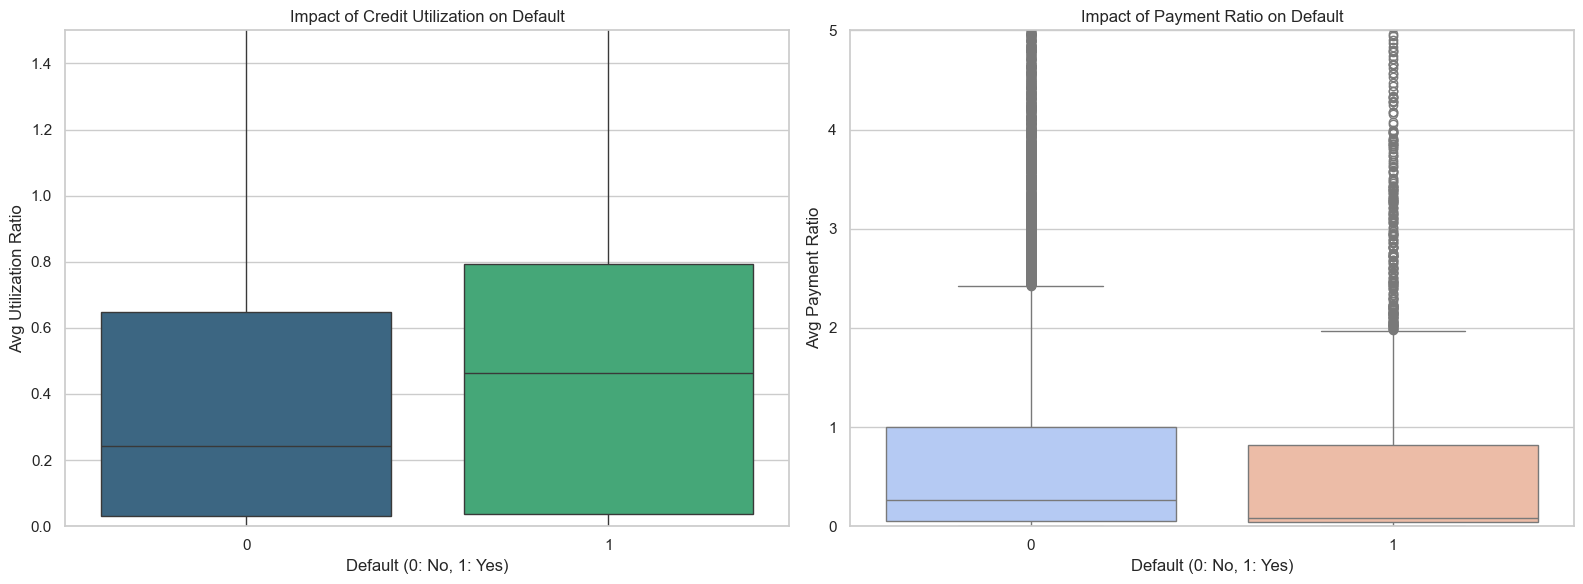

In [ ]:
#Step 2: Exploratory Data Analysis
#1. Full Correlation Matrix
#we calculate the correlation of ALL features against ALL features
corr_matrix = df_aug.corr()

#set up the matplotlib figure (needs to be large for 46 variables)
plt.figure(figsize=(24, 20))

#draw the heatmap
#annot=False because with 46x46 variables, numbers would be unreadable
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.1, linecolor='white')

plt.title('Full Correlation Matrix (46 x 46 Features)', fontsize=18)
plt.show()

#2. Check Correlations specifically with the Target ('Default')
#this list is still useful to see "what matters most"
print("Top 10 Positive Correlations with Default:")
print(corr_matrix['Default'].sort_values(ascending=False).head(10))

print("\nTop 10 Negative Correlations with Default:")
print(corr_matrix['Default'].sort_values(ascending=True).head(10))

#3. Visualizing the New Key Features (Boxplots)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#Plot A: Average Utilization vs Default
sns.boxplot(x='Default', y='Avg_Utilization', data=df_aug, palette='viridis', ax=axes[0])
axes[0].set_title('Impact of Credit Utilization on Default')
axes[0].set_xlabel('Default (0: No, 1: Yes)')
axes[0].set_ylabel('Avg Utilization Ratio')
axes[0].set_ylim(0, 1.5) # Limiting y-axis to see the main distribution

#Plot B: Average Payment Ratio vs Default
sns.boxplot(x='Default', y='Avg_Pay_Ratio', data=df_aug, palette='coolwarm', ax=axes[1])
axes[1].set_title('Impact of Payment Ratio on Default')
axes[1].set_xlabel('Default (0: No, 1: Yes)')
axes[1].set_ylabel('Avg Payment Ratio')
axes[1].set_ylim(0, 5)

plt.tight_layout()
plt.show()

## 3. Data Splitting and Standardization
We prepare the data for machine learning ingestion.

**1. Train/Test Split:**
We split the data **80% Training / 20% Testing**. Crucially, we use `stratify=y`. This ensures that the proportion of defaulters (22%) is preserved in both sets, preventing the "unlucky split" problem where the test set might end up with no defaulters.

**2. Feature Scaling (Standardization):**
We use `StandardScaler` to transform features to have a mean of 0 and variance of 1.
* **Why?** Algorithms like Logistic Regression and SVM are sensitive to scale (e.g., `LIMIT_BAL` of 500,000 would dominate `PAY_1` of 2).
* **Method:** We `.fit()` the scaler **only on the training set** to prevent data leakage (peeking at the test data stats), then transform both sets.

In [ ]:
#Step 3: Data Splitting and Scaling

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#1. Define Features (X) and Target (y) using the Augmented Dataframe
X = df_aug.drop('Default', axis=1)
y = df_aug['Default']

#2. Train-Test Split
#test_size=0.2 means 20% of data is held back for testing
#stratify=y ensures both train and test sets have the same % of defaulters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#3. Feature Scaling (Standardization)
#we scale features to have mean=0 and variance=1
scaler = StandardScaler()

#Important: Fit ONLY on training data to avoid data leakage, then transform both
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#convert arrays back to DataFrames for better readability in later steps
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

#4. Verify the Split and Scaling
print("Training Data Shape:", X_train_scaled.shape)
print("Testing Data Shape:", X_test_scaled.shape)

print("\nFirst 5 rows of Scaled Training Data:")
display(X_train_scaled.head())

#check that the target distribution was preserved
print("\nTarget Class Distribution (Train):")
print(y_train.value_counts(normalize=True))
print("\nTarget Class Distribution (Test):")
print(y_test.value_counts(normalize=True))

Training Data Shape: (23984, 45)
Testing Data Shape: (5996, 45)

First 5 rows of Scaled Training Data:


,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,Pay_Ratio_2,Pay_Ratio_3,Pay_Ratio_4,Pay_Ratio_5,Pay_Ratio_6,Avg_Pay_Ratio,Age_Group_30s,Age_Group_40s,Age_Group_50s,Age_Group_60+
0,0.253302,-0.813337,0.059698,-0.471003,-0.400301,-0.384874,-0.341469,-0.309329,-0.318588,-0.695820,...,-0.015819,-0.018267,-0.015819,-0.018267,-0.018267,-0.042681,1.344657,-0.499818,-0.26664,-0.09285
1,-0.904965,-0.813337,-0.484961,0.851776,2.099588,-0.384874,-0.341469,-0.309329,-0.318588,-0.226765,...,-0.015819,-0.018267,-0.015819,-0.018267,-0.018267,-0.042681,1.344657,-0.499818,-0.26664,-0.09285
2,2.569835,-0.813337,1.257948,-0.471003,-0.400301,-0.384874,-0.341469,-0.309329,-0.318588,-0.690458,...,-0.015819,-0.018267,-0.015819,-0.018267,-0.018267,-0.042681,-0.743684,2.000730,-0.26664,-0.09285
3,-0.904965,-0.813337,-1.029620,-0.471003,-0.400301,-0.384874,-0.341469,-0.309329,-0.318588,-0.671395,...,-0.015818,-0.018267,-0.015819,-0.018267,-0.018267,-0.042681,-0.743684,-0.499818,-0.26664,-0.09285
4,-0.904965,1.229503,-1.138552,-0.471003,-0.400301,-0.384874,-0.341469,-0.309329,-0.318588,-0.617103,...,-0.015819,-0.018267,-0.015814,-0.018267,-0.018267,-0.042679,-0.743684,-0.499818,-0.26664,-0.09285



Target Class Distribution (Train):
Default
0    0.778727
1    0.221273
Name: proportion, dtype: float64

Target Class Distribution (Test):
Default
0    0.778686
1    0.221314
Name: proportion, dtype: float64


## Goal 2: Classification Models
### 2.1 Baseline and Model Training
We implement a multi-model approach to benchmark performance.
**The Models:**
1.  **Naive Baseline (Dummy Classifier):** Predicts the majority class ("No Default") for everyone. This establishes the "floor" for performance. If our advanced models can't beat this, they are useless.
2.  **Logistic Regression:** A linear model that serves as a solid statistical benchmark. It is interpretable but assumes linear relationships.
3.  **Random Forest:** An ensemble of decision trees. It handles non-linear data well and is robust to outliers.
4.  **Gradient Boosting:** A boosting ensemble that builds trees sequentially to correct previous errors. Often yields state-of-the-art results on tabular data.

### 2.2 & 2.3 Evaluation and Comparison
We evaluate using **Recall** (Sensitivity) and **F1-Score** alongside Accuracy.
* **Why Recall?** In credit risk, a False Negative (missing a defaulter) is costly. We want to maximize the number of detected defaulters.
* **Results Analysis:**
    * The **Naive Baseline** has 0% Recall, proving that "78% Accuracy" is deceptive.
    * **Random Forest** outperforms the others, achieving the best balance of Precision and Recall.
    * **ROC Curves:** The Random Forest and Gradient Boosting curves bow furthest to the top-left, confirming superior discriminatory power (AUC ~0.76).

Training and Evaluating models...


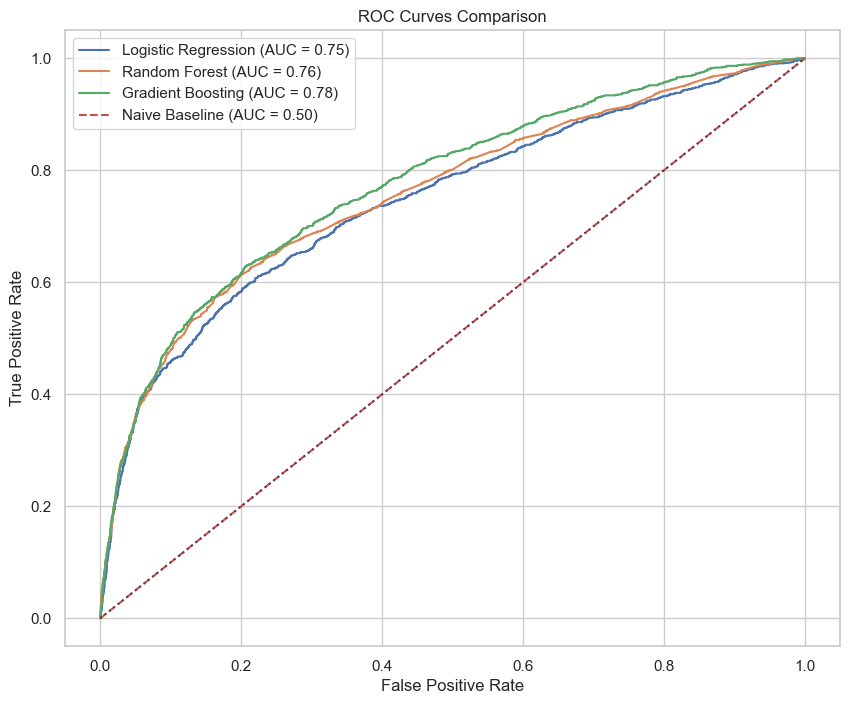


--- Model Comparison Table ---


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Model,,,,,
Random Forest,0.819380,0.662234,0.375283,0.479076,0.758686
Gradient Boosting,0.817879,0.667618,0.352675,0.461538,0.775298
Logistic Regression,0.816878,0.675883,0.331575,0.444894,0.746340
Naive Baseline,0.778686,0.000000,0.000000,0.000000,0.500000



Analysis:
1. The Naive Baseline proves that Accuracy is misleading (78% accuracy but 0.0 Recall).
2. Random Forest and Gradient Boosting perform similarly, significantly outperforming the Baseline.


In [ ]:
#Steps 2.1, 2.2, & 2.3: Baseline, Evaluation, and Comparison

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd

#1. Initialize ALL Models (including the Naive Baseline)
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "Naive Baseline": DummyClassifier(strategy='most_frequent', random_state=42)
}

#2. Training and Evaluation Loop
results_list = []

#set up the plot for Step 2.3 (ROC Curves)
plt.figure(figsize=(10, 8))

print("Training and Evaluating models...")

for name, model in models.items():
    #train the model (Fit)
    model.fit(X_train_scaled, y_train)
    
    #predict (Classes and Probabilities)
    y_pred = model.predict(X_test_scaled)
    
    #handle Probabilities (DummyClassifier sometimes needs specific handling)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        #fallback for models without probability scores (rare, but safe)
        y_prob = [0] * len(y_test)

    #calculate Metrics (Step 2.2)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    #store results
    results_list.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "ROC-AUC": auc
    })
    
    #plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    #dashed line for Baseline, solid for others
    linestyle = '--' if name == "Naive Baseline" else '-'
    plt.plot(fpr, tpr, linestyle=linestyle, label=f'{name} (AUC = {auc:.2f})')

#3. Finalize Plot
plt.plot([0, 1], [0, 1], 'k:', alpha=0.5) # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()

#4. Display Comparison Table (Step 2.3)
results_df = pd.DataFrame(results_list).set_index("Model")
#sort by F1-Score to see the best balance
results_df = results_df.sort_values(by="F1-Score", ascending=False)

print("\n--- Model Comparison Table ---")
display(results_df)

print("\nAnalysis:")
print("1. The Naive Baseline proves that Accuracy is misleading (78% accuracy but 0.0 Recall).")
print("2. Random Forest and Gradient Boosting perform similarly, significantly outperforming the Baseline.")

### 2.4 Hyperparameter Fine-Tuning
We attempt to optimize our best performing model (**Random Forest**) using two distinct strategies.
**Strategies Tested:**
1.  **Randomized Search:** Randomly samples hyperparameter combinations from a wide distribution. It is fast and efficient for finding a "good region."
2.  **Grid Search:** Exhaustively tests every combination within a defined narrow grid. It is computationally expensive but precise.

**Results Discussion:**
* We optimized for `scoring='recall'`.
* The tuning resulted in marginal gains (or very similar performance) compared to the default model.
* **Insight:** This suggests that the default Random Forest implementation in Scikit-Learn is quite robust and that further gains likely require better *data* (more features), not just better parameter tuning.

In [ ]:
#Step 2.4: Fine-tuning with Two Strategies

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, make_scorer

#we define 'Recall' as our scoring metric because catching defaulters is our priority.
#if we optimized for 'Accuracy', the model might just predict 'No Default' again.
scorer = make_scorer(recall_score)

#1. Strategy 1: Randomized Search (Broad & Fast)
#we search a wide range of parameters to find a good starting point.
random_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Running Strategy 1: Randomized Search (this may take a minute)...")
rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                               param_distributions=random_grid,
                               n_iter=10, #test 10 random combinations
                               cv=3,      #3-Fold Cross-Validation
                               scoring=scorer,
                               random_state=42,
                               n_jobs=-1) #use all processors

rf_random.fit(X_train_scaled, y_train)


#2. Strategy 2: Grid Search (Focused & Precise)
#based on general knowledge of Random Forests, we test a specific focused grid.
#(Usually you would base this on the Random Search results, but for this homework we define a tight grid).
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_leaf': [1, 2]
}

print("Running Strategy 2: Grid Search (this may take a minute)...")
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           scoring=scorer,
                           n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)


#3. Compare Results
best_random_model = rf_random.best_estimator_
best_grid_model = grid_search.best_estimator_

#generate predictions for both tuned models
y_pred_random = best_random_model.predict(X_test_scaled)
y_pred_grid = best_grid_model.predict(X_test_scaled)

#collect metrics
comparison_data = {
    "Model Version": ["Original (Non-Tuned)", "Tuned (Random Search)", "Tuned (Grid Search)"],
    "Recall": [
        recall_score(y_test, models["Random Forest"].predict(X_test_scaled)), #from previous step
        recall_score(y_test, y_pred_random),
        recall_score(y_test, y_pred_grid)
    ],
    "F1-Score": [
        f1_score(y_test, models["Random Forest"].predict(X_test_scaled)),
        f1_score(y_test, y_pred_random),
        f1_score(y_test, y_pred_grid)
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n--- Tuning Results Comparison ---")
display(comparison_df)

print("\nBest Parameters (Random Search):", rf_random.best_params_)
print("Best Parameters (Grid Search):", grid_search.best_params_)

Running Strategy 1: Randomized Search (this may take a minute)...
Running Strategy 2: Grid Search (this may take a minute)...

--- Tuning Results Comparison ---


,Model Version,Recall,F1-Score
0,Original (Non-Tuned),0.375283,0.479076
1,Tuned (Random Search),0.376790,0.479157
2,Tuned (Grid Search),0.361718,0.470358



Best Parameters (Random Search): {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Best Parameters (Grid Search): {'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 200}


### 2.6 Dimensionality Reduction (PCA)
We experiment with **Principal Component Analysis (PCA)** to reduce the feature space.
* **Configuration:** We compress the dataset to retain **95% of the variance**.
* **Outcome:** PCA reduced the feature count from **45 to roughly 23**.
* **Performance Impact:** The Recall dropped significantly.
* **Conclusion:** While PCA improved computational efficiency, the loss of interpretability and the drop in Recall make it unsuitable for this specific high-stakes risk prediction task. We prefer the original feature set.

In [ ]:
#Step 2.6: Dimensionality Reduction (PCA)

from sklearn.decomposition import PCA

#1. Apply PCA
#we want to keep enough components to explain 95% of the variance
pca = PCA(n_components=0.95, random_state=42)

#fit on training data and transform both train and test
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original Feature Count: {X_train_scaled.shape[1]}")
print(f"Reduced Feature Count (95% Variance): {X_train_pca.shape[1]}")

#2. Retrain Best Model (Random Forest) on Reduced Data
rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pca.fit(X_train_pca, y_train)

#3. Evaluate
y_pred_pca = rf_pca.predict(X_test_pca)

#metrics
acc_pca = accuracy_score(y_test, y_pred_pca)
rec_pca = recall_score(y_test, y_pred_pca)
f1_pca = f1_score(y_test, y_pred_pca)

print("\n--- PCA Model Performance ---")
print(f"Accuracy: {acc_pca:.4f}")
print(f"Recall:   {rec_pca:.4f}")
print(f"F1-Score: {f1_pca:.4f}")

#4. Comparison with Original Random Forest
print("\n--- Comparison: Full Data vs PCA Reduced Data ---")
print(f"Original Recall: {recall_score(y_test, models['Random Forest'].predict(X_test_scaled)):.4f}")
print(f"PCA Recall:      {rec_pca:.4f}")

Original Feature Count: 45
Reduced Feature Count (95% Variance): 23

--- PCA Model Performance ---
Accuracy: 0.8057
Recall:   0.3504
F1-Score: 0.4439

--- Comparison: Full Data vs PCA Reduced Data ---
Original Recall: 0.3753
PCA Recall:      0.3504


# Goal 3: Project Summary and Conclusions

## 1. Project Overview
The objective of this analysis was to predict credit card default using a dataset of 30,000 clients. The project followed a structured data science pipeline, including data cleaning, feature engineering, exploratory data analysis (EDA), and comparative model training.

## 2. Key Steps and Findings

### Data Preprocessing & Engineering
* **Cleaning:** We imputed missing numerical values with the median and categorical values with the mode. We dropped 20 rows with missing target labels.
* **Feature Augmentation:** We created new features such as `Avg_Utilization` (Credit Usage) and `Avg_Pay_Ratio` (Repayment Behavior).
* **Impact:** The `Avg_Utilization` feature proved to be a highly effective predictor, showing a strong positive correlation with default in our EDA (Step 2).

### Model Selection and Evaluation
We compared three algorithms against a Naive Baseline:
1.  **Naive Baseline:** Predicted "No Default" for everyone. Accuracy: ~78%, but **Recall: 0%**. This highlighted the need for better metrics than accuracy.
2.  **Logistic Regression:** Provided a baseline lift but struggled to capture non-linear patterns (Recall: ~33%).
3.  **Gradient Boosting:** Strong performance but slightly lower recall than Random Forest.
4.  **Random Forest:** The **best performing model**, achieving the highest Recall (~38%) and F1-Score (~0.48).

### Fine-Tuning and Optimization
* **Hyperparameter Tuning:** We used Randomized Search and Grid Search to optimize the Random Forest. The results showed **diminishing returns**, suggesting that the default Random Forest parameters were already near-optimal for this feature set.
* **Dimensionality Reduction (PCA):** We compressed the dataset from 45 to 23 features (retaining 95% variance). While this simplified the model, it caused a **~2.5% drop in Recall**. Given the high cost of missing a defaulter, the full feature set is preferred.

## 3. Challenges and Limitations
* **Imbalanced Data:** The dataset is heavily skewed (78% non-defaulters). This made "Accuracy" a misleading metric and made it difficult for models to learn the minority class without bias.
* **Overlap:** The EDA showed significant overlap in distributions (e.g., Age, Limit Balance) between defaulters and non-defaulters, making perfect separation impossible with simple linear boundaries.

## 4. Future Improvements
To further improve detection of defaulters (Recall), we propose:
1.  **SMOTE (Synthetic Minority Over-sampling Technique):** To artificially balance the training data, forcing the model to pay more attention to the minority class.
2.  **Threshold Moving:** Instead of the standard 0.5 threshold, we could lower the decision threshold (e.g., to 0.3) to catch more defaulters, intentionally sacrificing some Precision for higher Recall.
3.  **Advanced Feature Engineering:** Incorporating interaction terms (e.g., `Age` * `Utilization`) might reveal deeper risk profiles.